# Life-time of particles

This code is structured in such a way that we keep making a function of that gets the lambdas via certain method and shoving that into `compare_fit()`.

## Helper functions, imports & global variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.integrate

bins = [5, 10, 50, 100] # Amount of bins used for the histograms. Given in the exercise.

# Our fit function that we use everywhere; a=lambda1, b=lambda2.
f = lambda x,params: 0.5*(params[0]*np.exp(-params[0]*x) + params[1]*np.exp(-params[1]*x))

# For any minimizing function like least squares. This is used as x0. The docs calls this "Initial guess on independent variables"
# But the exercise calls it "starting parameters" so we went along with that.
starting_values = (10,50) 

#Generating the two random datasets of exponential distributions (lambda=10,lambda=50)
s1 = np.random.exponential((1/10),1000)
s2 = np.random.exponential((1/50),1000)

# "mixing" data sets
s = np.append(s1, s2)

def compare_fit(func, method: str="", caption: bool=True):
    """
    Uses your method of calculating lambda1 and lamba2 to plot the fitting functions through histograms with different amount of bins

    Arguments:
        func            (function)  Your function that calculates the lambdas, this MUST return [lambda1, lambda2]
        method          (string)    Used to put in the title of the figure.
        caption         (boolean)   Whether you want to caption the figures with the values of lambda or not.
    """

    fig,ax=plt.subplots(1, 4, figsize=(15,5), constrained_layout=True)

    # Sure you can use the middle of the histograms for x values, but why? This is so much smoother. 
    # This is just used to plot the fit functions and nothing else.
    x = np.linspace(0, 1, 1000) 

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    for k,i in enumerate(bins):
        n = ax[k].hist(s, i, color='purple', density=True)
        
        if caption:
            lambdas = func(n) # lambdas = [lambda1 , lambda2]
            textstr = '\n'.join((
            r'$\lambda_1=%.2f$' % (lambdas[0], ),
            r'$\lambda_2=%.2f$' % (lambdas[1], )))
            ax[k].text(0.6, 0.95, textstr, transform=ax[k].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        else:
            lambdas= func()
        ax[k].plot(x, f(x, lambdas), color='orange') # Plot the fit function
    fig.suptitle(f"Histograms of mixed data - {method}")
    plt.show()

# The main idea of integration here is taken from the lecturer's notebook on brightspace. This was allowed by our TA.
# See his function called "pdf_to_prob()"
def bin_probability(params, fit_pdf, bin_edges):
    """
    Gives you the probability associated with each bin given a fitting function (PDF) 
    by integration of the function over the bin.

    Arguments:
        params          (array-like)                The parameters that the fitting function f takes                     
        fit_pdf         (function)                  The fitting function that we want to test the parameters on
        bin_edges       (array-like)                Array of bin edges as returned by plt.hist() or the numpy equivalent
    Returns:
        integral_value  (array-like)                Array with the probability of each bin.

    """

    int_f = lambda x: fit_pdf(x,params) # Evaluates PDF for integration purposes

    integral_val = np.empty(0)

    for a,b in np.nditer([bin_edges[:-1],bin_edges[1:]]):   # a and b will be the integration bounds.
        val, err = scipy.integrate.quad(int_f,a,b)
        integral_val = np.append(integral_val,val)
    return integral_val

def res(params, fit_pdf, bin_edges, hist, error, integration):
    """

    Calculates the vector of residuals given a histogram & a fit function of the form (x, parameters).
    This is the chi in the chi squared test except it's not summed up but stored in an array/vector.
    Chi squared would be the magnitude of this vector.

    Arguments:
        params      (array-like)                The parameters that the fitting function f takes                     
        fit_pdf     (function)                  The fitting function that we want to test the parameters on
        bin_edges   (array-like)                Array of bin edges as returned by plt.hist() or the numpy equivalent
        hist        (array-like)                Array of heights of the histogram
        yerr        (array-like)                Dataset containing the corresponding error of every value.
        error       (boolean)                   Whether we care about statistical error.
        integration (boolean)                   Whether to use integration for bin probabilities. Otherwise we just do fit function @ bin_centre * bin_width.
    Returns:
        result  (array)                         Array of residual values for given parameters on the fit function.
    """

    bins_c = (bin_edges[:-1]+bin_edges[1:])/2   # Bin centres
    bins_w = bin_edges[1:] - bin_edges[:-1]     # Bin widths
    
    # Either integrate the fit function over the bins or just evaluate: fit function @ bin_centre * bin_width at every bin.
    # So the "prediction" here is for the total probability between the two bin edges.
    prediction = bin_probability(params, fit_pdf, bin_edges) if integration else bins_w * fit_pdf(bins_c, params)

    # We want to get rid of indices where the histogram is 0.
    # First of all, we can't take the sqrt of those values. Secondly, why would we want those in our residual vector.
    nonzero_i = hist!=0

    # if we don't care about error we just divide by 1. The error is sqrt because chi^2=(O-E)^2/E
    return ((bins_w[nonzero_i] * hist[nonzero_i] - prediction[nonzero_i])/(np.sqrt(hist[nonzero_i]) if error else 1)) 

## Method of Moments

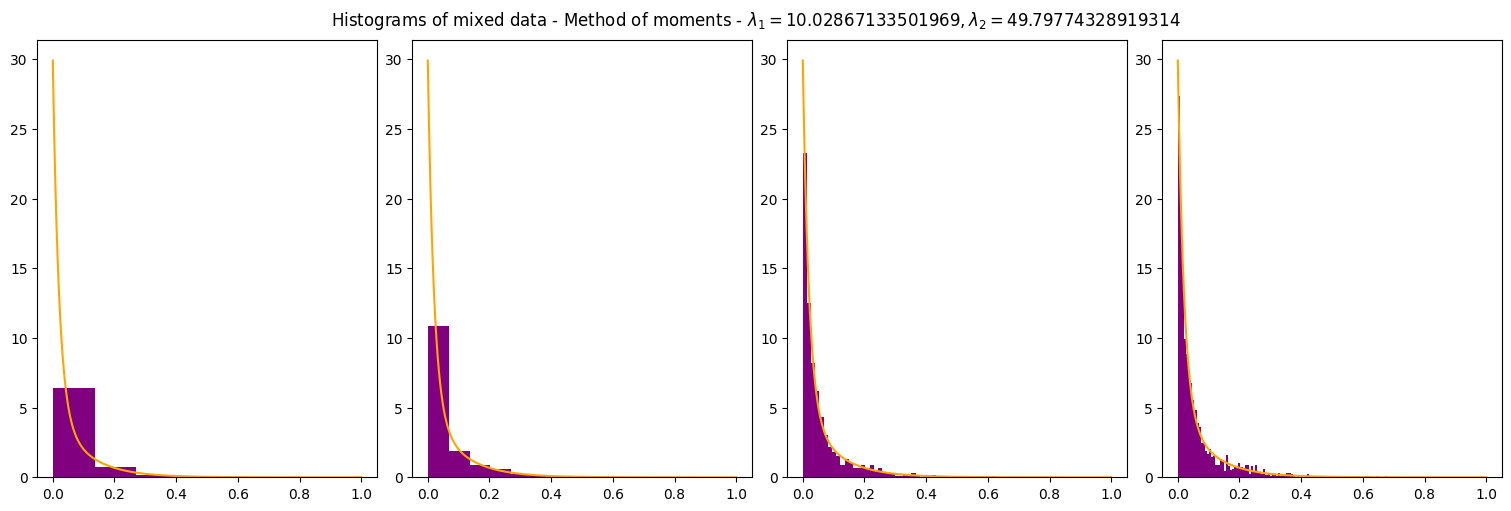

In [2]:
def k_moment(data, k=1):
    """
    This function returns the estimate of the kth moment of the data set.
    """
    n=len(data)
    sum=np.sum(data**k)
    return (1/n)*sum


def lambdas_mm():
    #We are trying to estimate two parameters so we only need 2 moments.
    (m1,m2)= (k_moment(s,1),k_moment(s,2))

    # Using the formulas we derived:
    lambda1=(m1+np.sqrt(0.5*m2-m1**2))**(-1)
    lambda2=(m1-np.sqrt(0.5*m2-m1**2))**(-1)

    return [lambda1,lambda2]

# Here we just wanna plot but the hist_values and bin_edges will be used later in the least squares method.
compare_fit(lambdas_mm, f"Method of moments - $\lambda_1 = {lambdas_mm()[0]}, \lambda_2 = {lambdas_mm()[1]}$", caption=False)

## Method of Least Squares

### Without statistical error

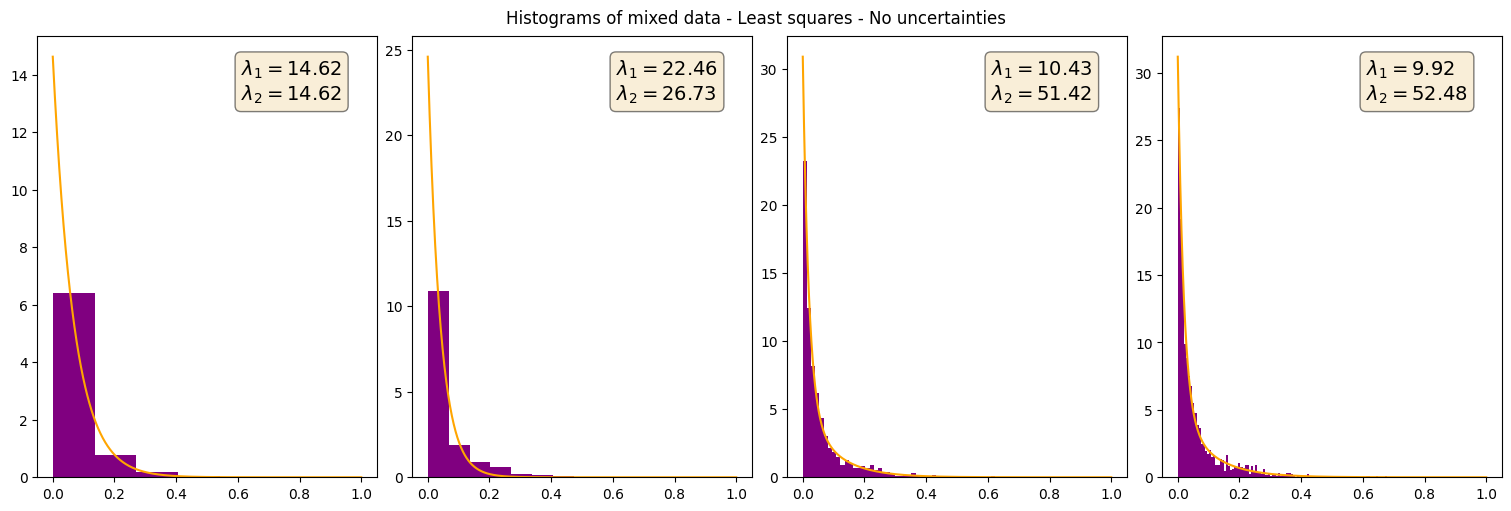

In [3]:
def lambdas_ls1(hist):
    result = scipy.optimize.least_squares(res, starting_values, args=(f,hist[1], hist[0], False, False), bounds=(1,100))
    return [result.x[0], result.x[1]]

compare_fit(lambdas_ls1, "Least squares - No uncertainties")

### With statistical error

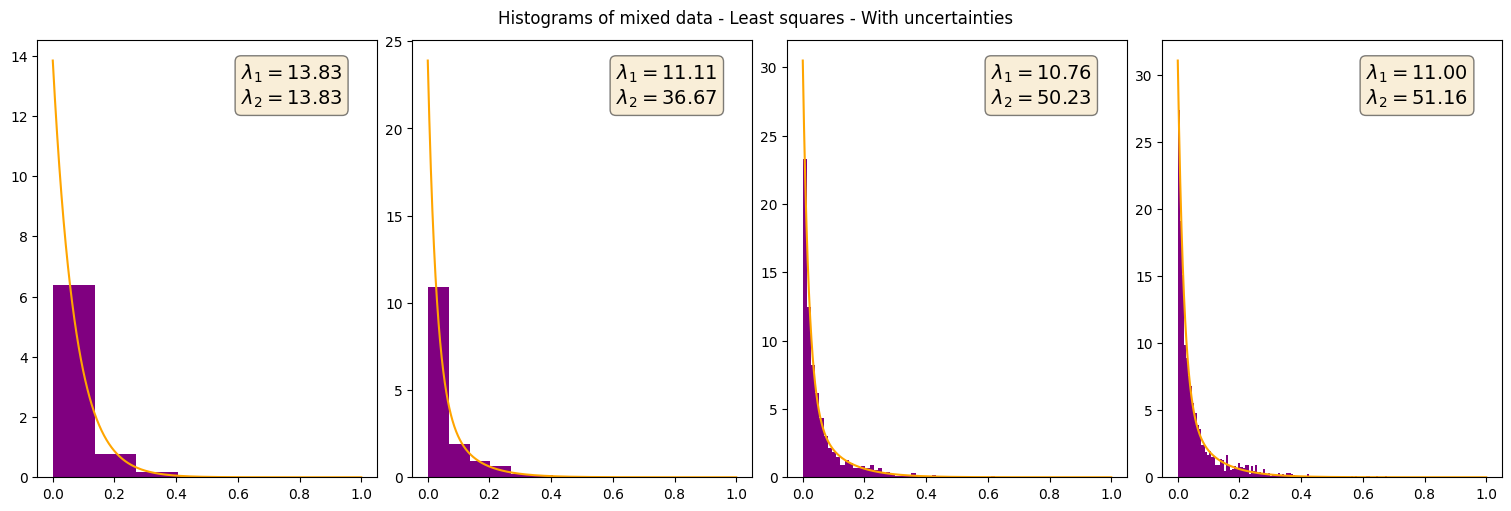

In [4]:
# What's the difference? The argument "error" is set to "True" in the residual function now.
def lambdas_ls2(hist):
    result = scipy.optimize.least_squares(res, starting_values, args=(f,hist[1], hist[0], True, False), bounds=(1,100))
    return [result.x[0], result.x[1]]

compare_fit(lambdas_ls2, f"Least squares - With uncertainties")

### With integration

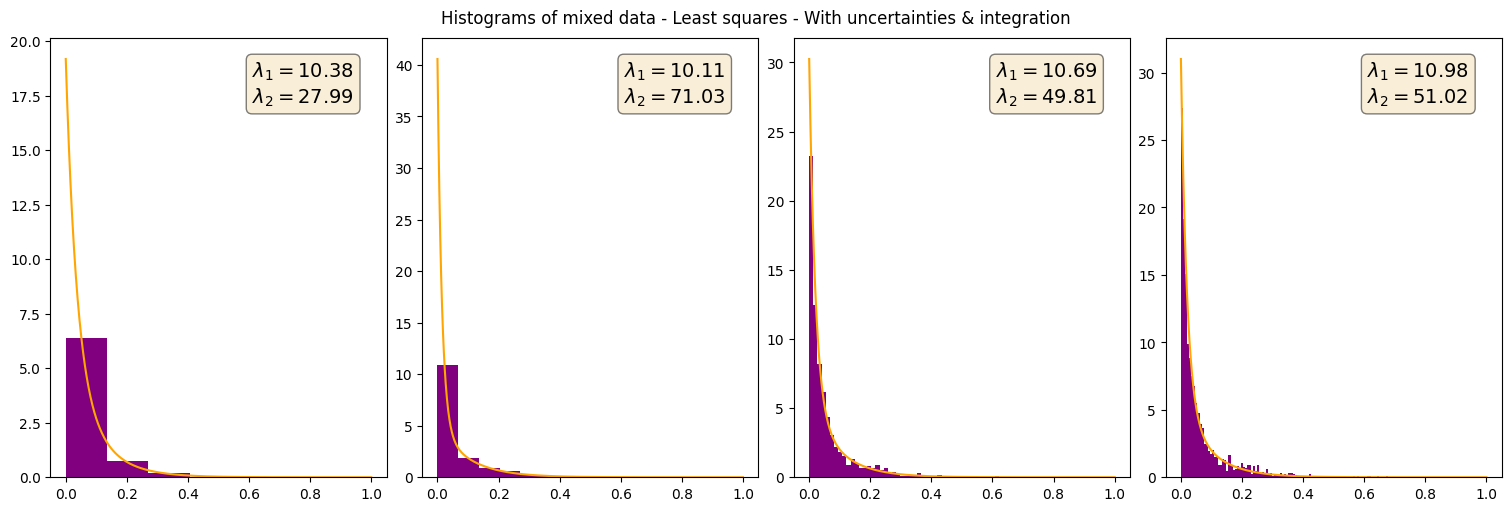

In [5]:
# What's the difference? The argument "integration" is set to "True" in the residual function now.
def lambdas_ls3(hist):
    result = scipy.optimize.least_squares(res, starting_values, args=(f,hist[1], hist[0], True, True), bounds=(1,100))
    return [result.x[0], result.x[1]]

compare_fit(lambdas_ls3, f"Least squares - With uncertainties & integration")

## Method of Maximum Likelyhood

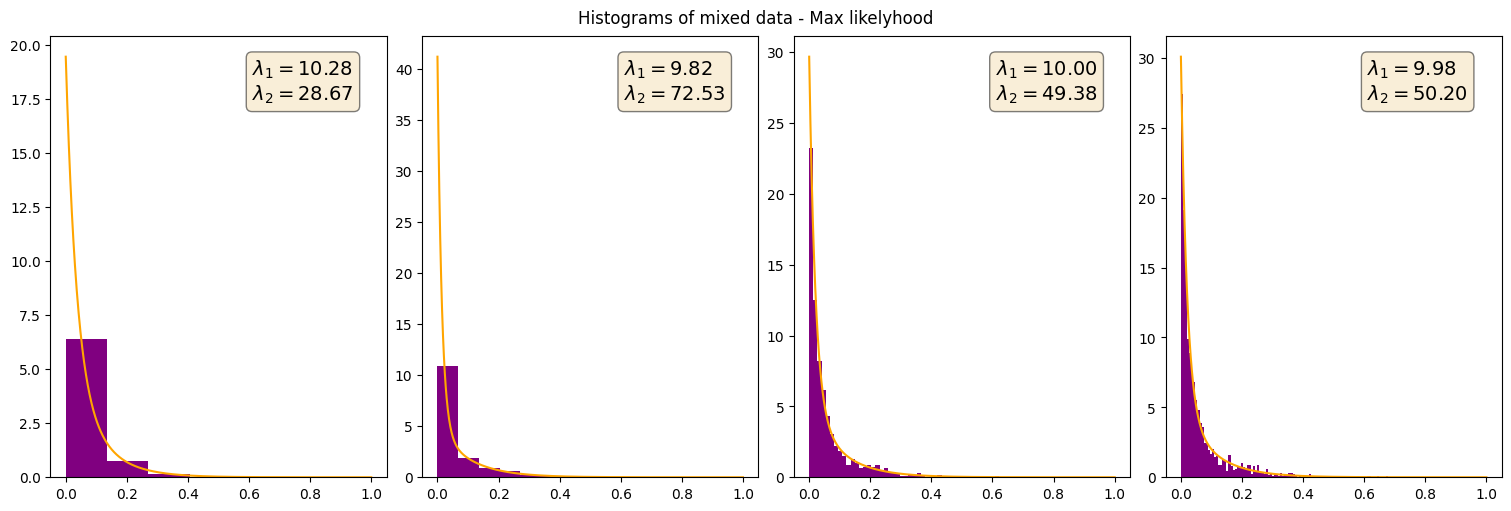

In [6]:
def minus_loglikelyhood(parameters, pdf, histogram, bin_list):
    '''
    Via this function we can compute the probability of obtaining a particular histogram given the parameters of 
    a probability density function. The result is the product of the probabability of each bin. As we want to maximize the result, 
    we put a negative sign before the returned result so it can be minimazed. In this way, by computing the logarithm of the result
    and minimazing its negative we will obtain the lambdas.

    Input parameters:
        parameters -- parameters to passed to the pdf, in this case lambda1 and lambda2
        pdf -- the function used
        histogram -- number of observed entries in each bin
        bin_list -- edges of the bins of the histogram
    
    Output peturns:
        return -- -sum(log(likelyhood of each bin))
    '''
    return -np.sum(histogram * np.log(bin_probability(parameters, pdf, bin_list)))

def lambdas_ml(hist):
    max_likelyhood = scipy.optimize.minimize(minus_loglikelyhood, starting_values, args=(f, hist[0], hist[1]))
    return [max_likelyhood.x[0], max_likelyhood.x[1]]

compare_fit(lambdas_ml, "Max likelyhood")